In [1]:
from astropy import convolution
import numpy as np
import matplotlib.pyplot as plt
import re
from PIL import Image
import os
import math
from scipy.interpolate import CubicSpline
from tqdm import tqdm
# %matplotlib ipympl

In [2]:
# ccd_px_side_length_micron = 2.4 # ASI183MM
# ccd_width_px = 5496 # ASI183MM
# ccd_height_px = 3672 # ASI183MM

ccd_px_side_length_micron = 2.3 # ASI294MM
ccd_width_px = 8288 # ASI294MM
ccd_height_px = 5644 # ASI294MM

plate_scale = 206265 * ccd_px_side_length_micron / (1000*1800) # arcsec/px


def rot(psf,ang,ang0):
    im = Image.fromarray(psf)
    im = im.rotate(ang0-ang)
    im = np.array(im)
    im = im/np.sum(im)
    return im

def shift_down(mat,rows):
    mat2 = np.zeros(mat.shape)
    for i in range(mat.shape[0]):
        j =  (i-rows) % mat.shape[1]
        mat2[i,j] = 1
        
    return  mat2 @ mat

def micind_to_pxind(w_ind,h_ind,cw_mic_ind,ch_mic_ind,cw_px_ind,ch_px_ind,spacing_micron):
    w_mic = (w_ind - cw_mic_ind)*spacing_micron
    h_mic = (h_ind - ch_mic_ind)*spacing_micron
    w_px = w_mic/ccd_px_side_length_micron
    h_px = h_mic/ccd_px_side_length_micron
    w_px_ind = int(w_px) + cw_px_ind 
    h_px_ind = int(h_px) + ch_px_ind
    return int(w_px_ind),int(h_px_ind)

def parse_psf_metadata(file_path):
    f = open(file_path, 'r', encoding='utf-16')
    s = f.read()
    f.close()
    m = re.search(r'spacing is (\d+\.\d+)', s)
    spacing = float(m.group(1))
    m = re.search(r'at (\d+\.\d+)', s)
    field_angle_deg = float(m.group(1))
    m = re.search(r'Reference Coordinates: (\d+\.\d+E[+-]\d+), (\d+\.\d+E[+-]\d+)', s)
    cw_mic = float(m.group(1))*1000
    ch_mic = float(m.group(2))*1000
    m = re.search(r'Center point is: row (\d+), column (\d+)', s)
    ch_mic_ind = int(m.group(1))
    cw_mic_ind = int(m.group(2))
    return spacing,cw_mic,ch_mic,cw_mic_ind,ch_mic_ind,field_angle_deg

def correct_psf_artifacts(ker):
    ker[np.where(ker<3e-3)] = 1e-9 # Remove non-zero background; trial and error shows 3e-3 threshold good for PSF max value normalized to 1
    ker = shift_down(ker,int(ker.shape[0]*0.475)) # Zemax PSF is cut off at the top, so shift it down to center it; 0.49 is a trial and error value

    # now the whole PSF isn't cut off, but the maximum value is not in the center
    ker = np.concatenate((ker,np.full_like(ker,ker.min())),axis=0) # zero pad from the top
    ker = np.concatenate((np.full((ker.shape[0],ker.shape[1]//2),ker.min()),ker,np.full((ker.shape[0],ker.shape[1]//2),ker.min())),axis=1) # zero pad from the sides
    ker = shift_down(ker,ker.shape[0]//2 - np.unravel_index(np.argmax(ker, axis=None), ker.shape)[0]) # shift the PSF to center it around the maximum value
    return ker

def convert_psf(file_path):
    # Make the Zemax PSF into a kernel usable by the simulator

    spacing_micron,cw_mic,ch_mic,cw_mic_ind,ch_mic_ind,field_angle_deg = parse_psf_metadata(file_path)
    psf_mic = np.loadtxt(file_path,dtype=float,skiprows=18,encoding='utf-16')
    psf_mic = correct_psf_artifacts(psf_mic) # Correct for Zemax PSF artifacts
    cw_mic_ind, ch_mic_ind = np.unravel_index(np.argmax(psf_mic, axis=None), psf_mic.shape) # previous function fixes the reference (center) point to the maximum intensity point
    ker_size = int(np.ceil(psf_mic.shape[0] * spacing_micron / ccd_px_side_length_micron))
    if (ker_size % 2 == 0): ker_size += 1 
    ch_px_ind = ker_size/2 - 1 # reference point in the new kernel is the center
    cw_px_ind = ker_size/2 - 1
    psf_px = np.zeros((ker_size,ker_size))
    for i in range(psf_mic.shape[0]):
        for j in range(psf_mic.shape[1]):
            jj , ii = micind_to_pxind(j,i,cw_mic_ind,ch_mic_ind,cw_px_ind,ch_px_ind,spacing_micron)
            psf_px[ker_size-1-ii,jj] += psf_mic[i,j]
    r = field_angle_deg * 3600 / plate_scale # field angle is related to image space radial distance through the plate scale
    ang0 = np.rad2deg(np.arctan2(ch_mic,cw_mic))
    psf_px = psf_px/math.fsum(np.ravel(psf_px))
    return psf_px, r, ang0

def get_shadow_by_col():
    a = np.fromfile('./fiffa_data/MAST_BFD17_ASI1600_GuideMode.dat',sep=' ')
    y = np.fromfile('./fiffa_data/MAST_BFD17_ASI1600_YCord.dat',sep=' ')
    w_vec0 = np.unique(y)
    eta_vec0 = []
    for w0 in w_vec0:
        eta_vec0.append(np.mean(a[y == w0]))
    w_vec_px = np.arange(0,ccd_width_px,1)
    w_vec_deg = (w_vec_px - int(ccd_width_px/2 - 1))* plate_scale / 3600
    cs = CubicSpline(w_vec0,eta_vec0)
    eta_vec = cs(w_vec_deg)/100
    eta_vec[eta_vec > 1] = 1
    eta_vec[eta_vec < 0] = 0
    return eta_vec


In [4]:
psf_u_lst = []
r_u_lst = []
ang0_u_lst = []

for i in tqdm(range(20)):
    file_path_u = os.path.join('..','psf', f'psf{i+1}.txt')
    psf_u, r_u ,ang0_u = convert_psf(file_path_u)
    psf_u_lst.append(psf_u)
    r_u_lst.append(int(r_u))
    ang0_u_lst.append(ang0_u)

100%|██████████| 20/20 [41:25<00:00, 124.30s/it]


In [12]:
r_dict = {r: i for i, r in enumerate(r_u_lst)}
for i,r in enumerate(r_u_lst):
    file_name = os.path.join('..','essential_files','kernels_294', str.format(r'r={}.npy',r))
    np.save(file_name , arr = psf_u_lst[r_dict[r]])

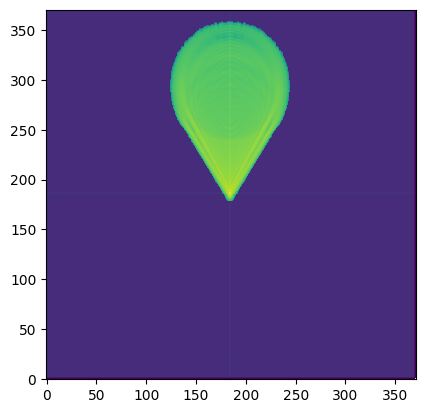

In [10]:
from matplotlib.colors import LogNorm
# ker = np.load(r'../essential_files/kernels_294/r=1327.npy')
# ker, r, ang0 = convert_psf(r'../psf/psf10.txt')
ker = psf_u_lst[1]
plt.imshow(ker,origin='lower',norm=LogNorm())
plt.show()